In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # Not entirely sure how to import the raw .mat data
from scipy.special import gamma
from mne_connectivity import spectral_connectivity_time
from mne_connectivity.viz import plot_sensors_connectivity
from mne_connectivity import read_connectivity
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout
from math import log

import autoreject

all_file_numbers=range(512, 629, 1)

file_name="Matlab Files/554_Depression_REST.mat"
file_number=file_name[13:16]
mat_data = loadmat(file_name)

In [4]:
eeg_signal = mat_data['EEG']['data'][0,0]

sampling_rate =  mat_data['EEG']['srate'][0,0][0,0]

chanlocs = mat_data['EEG']['chanlocs'][0,0]
channel_names = [str(chan[0]) for chan in chanlocs['labels'][0]]

In [6]:
print(channel_names)
print(len(channel_names))
print(channel_names[59])

['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEOG', 'VEOG', 'EKG']
67
CB1


In [8]:
info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types=['eeg']*59+['misc']+['eeg']*3+['misc']+['eog']*2+['ecg'])

In [10]:
info.set_montage("standard_1020", match_case=False, on_missing='warn')

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 62 EEG, 2 misc, 2 EOG, 1 ECG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 500.0 Hz
>

In [12]:
raw = mne.io.RawArray(eeg_signal, info)

Creating RawArray with float64 data, n_channels=67, n_times=267360
    Range : 0 ... 267359 =      0.000 ...   534.718 secs
Ready.


raw.plot(scalings='auto')

In [15]:
# Let's work with theta data for now

filtered_data = raw.copy().filter(l_freq=1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Using EOG channels: HEOG, VEOG
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 47 significant peaks
Number of EOG events detected: 47
Not setting metadata
47 matching events found
No baseline correction applied
Using data from preloaded Raw for 47 events and 501 original time points ...
0 bad epochs dropped
Applying baseline cor

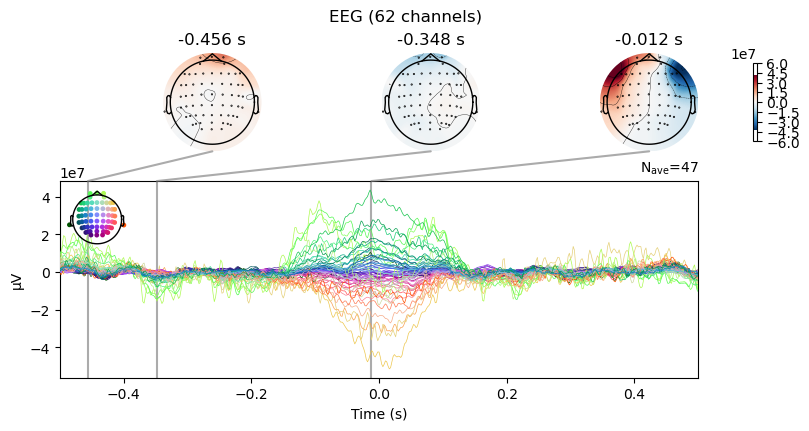

In [17]:
eog_evoked = mne.preprocessing.create_eog_epochs(filtered_data).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint();

Using channel EKG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5000 samples (10.000 s)

Number of ECG events detected : 777 (average pulse 87.18581687612208 / min.)
Not setting metadata
777 matching events found
No baseline correction applied
Using data from preloaded Raw for 777 events and 501 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


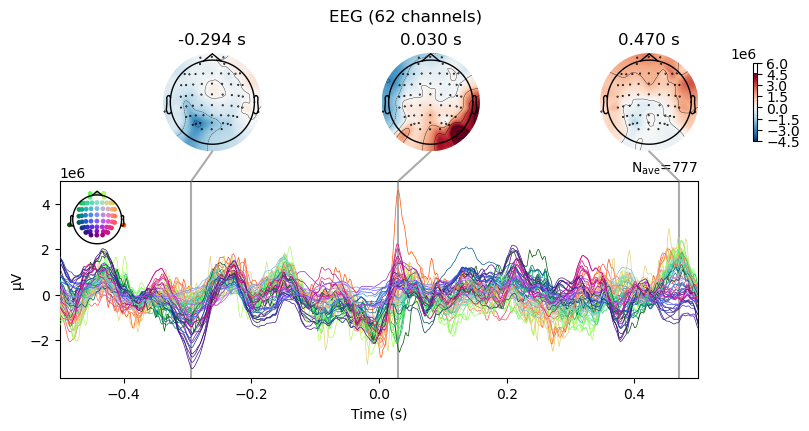

In [18]:
ecg_evoked = mne.preprocessing.create_ecg_epochs(filtered_data).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint();

In [20]:
filtered_data.plot(scalings='auto')

Using qt as 2D backend.


In [22]:
epochs = mne.make_fixed_length_epochs(filtered_data, duration = 3, preload = True)

Not setting metadata
178 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 178 events and 1500 original time points ...
0 bad epochs dropped


In [25]:
epochs.plot(scalings='auto')

In [27]:
ar = autoreject.AutoReject(random_state=42)
ar.fit(epochs)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/62 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/62 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/178 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/178 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/178 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/178 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


AutoReject(consensus=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
      cv=10, n_interpolate=array([ 1,  4, 32]), n_jobs=1, picks=None,
      random_state=42, thresh_method='bayesian_optimization', verbose=True)

In [28]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

  0%|          | Repairing epochs : 0/178 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


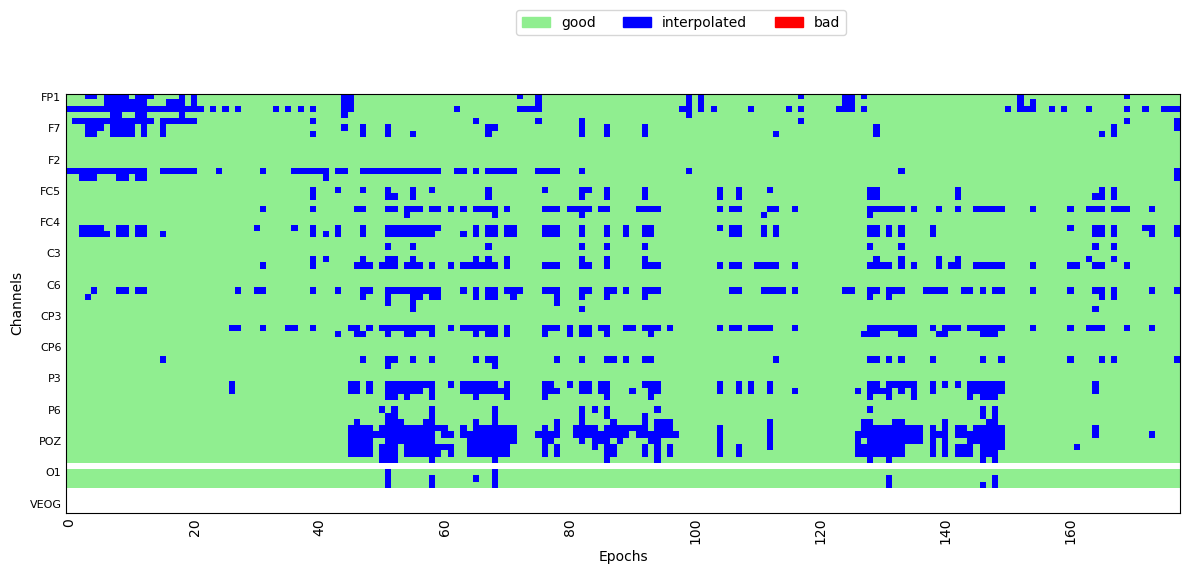

In [33]:
reject_log.plot('horizontal');

In [35]:
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T*1e6, 'r', zorder = -1);
epochs_ar.average().plot(axes=plt.gca());

RuntimeError: epochs.average() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

In [74]:
epochs[reject_log.bad_epochs].plot(scalings='auto', title='Bad epochs from first autoreject')

In [46]:
epochs_ar.plot(scalings='auto', title='Cleaned epochs from first autoreject')

In [78]:
ica=mne.preprocessing.ICA(max_iter='auto', random_state=42)
ica.fit(epochs[~reject_log.bad_epochs])
ica

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 62 components
Fitting ICA took 16.0s.


<ICA | epochs decomposition, method: fastica (fit in 55 iterations on 247500 samples), 62 ICA components (62 PCA components available), channel types: eeg, no sources marked for exclusion>

In [80]:
print(ica.get_explained_variance_ratio(filtered_data))
ica.plot_sources(filtered_data.copy().pick('eeg'))

{'eeg': 1.0}
Creating RawArray with float64 data, n_channels=62, n_times=252860
    Range : 0 ... 252859 =      0.000 ...   505.718 secs
Ready.


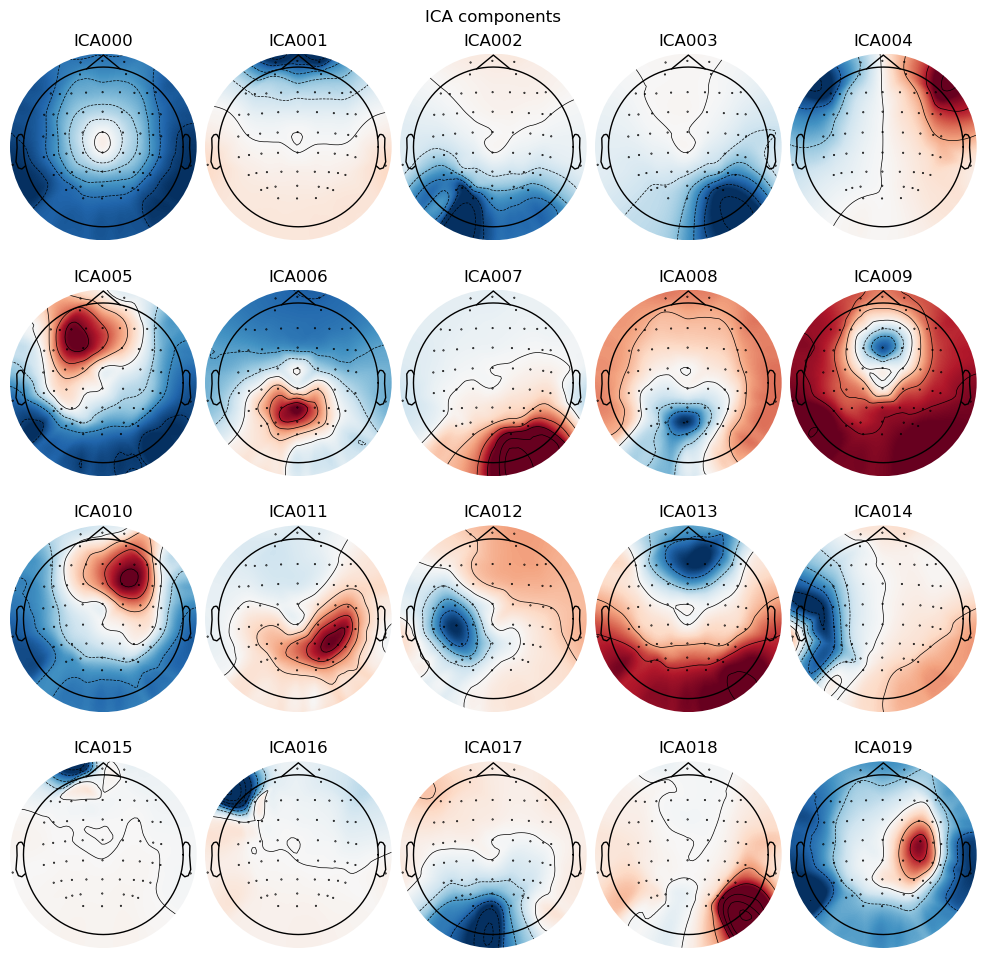

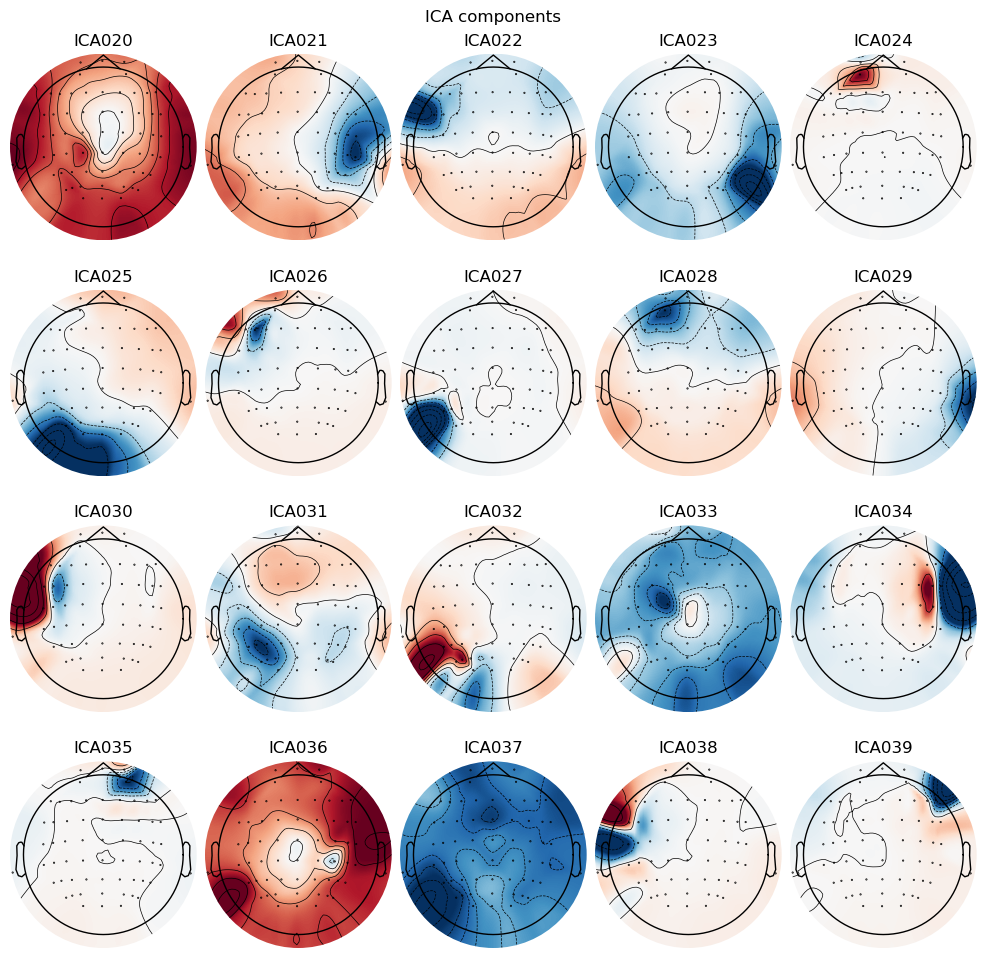

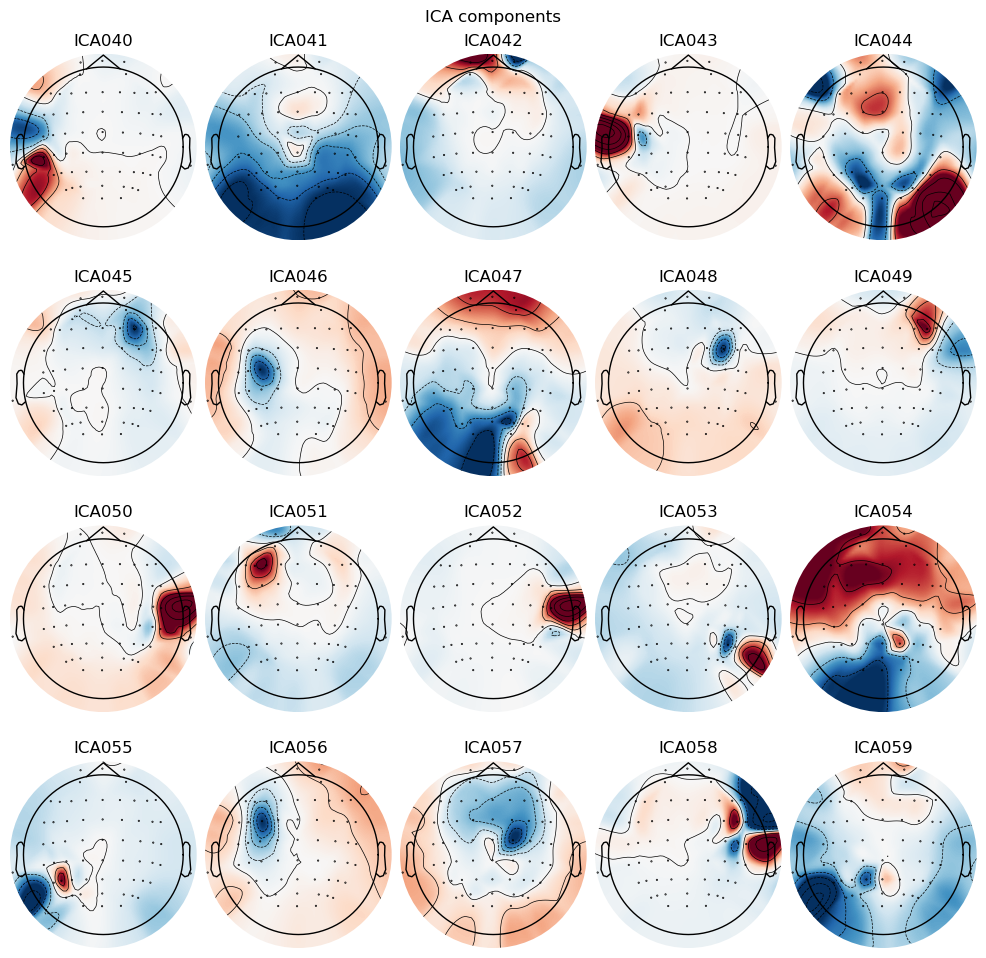

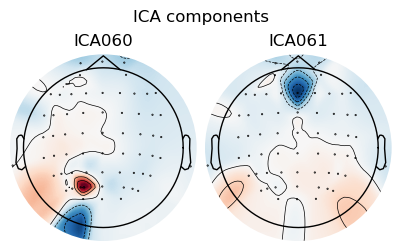

In [82]:
ica.plot_components();

Using threshold: 0.23 for CTPS ECG detection
[]


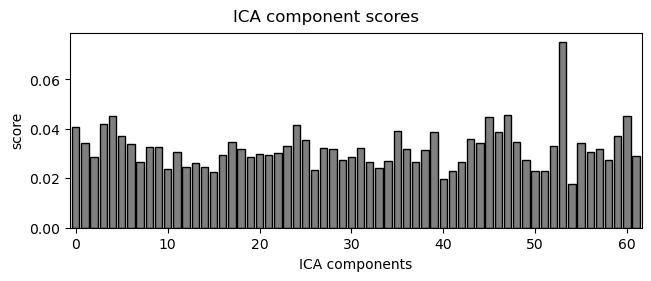

In [84]:
ecg_indices, ecg_scores = ica.find_bads_ecg(epochs_ar, ch_name='FPZ')
print(ecg_indices)
ica.plot_scores(ecg_scores);

Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

[1, 4]


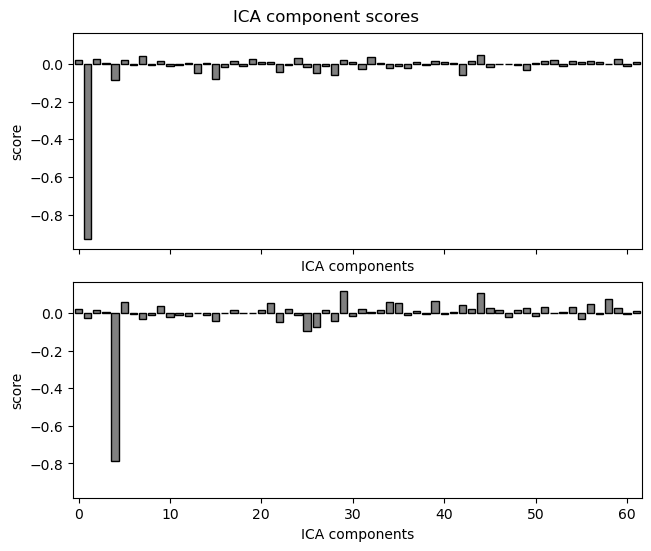

In [86]:
eog_indices, eog_scores = ica.find_bads_eog(filtered_data)
print(eog_indices)
ica.plot_scores(eog_scores);

Applying ICA to Evoked instance
    Transforming to ICA space (62 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


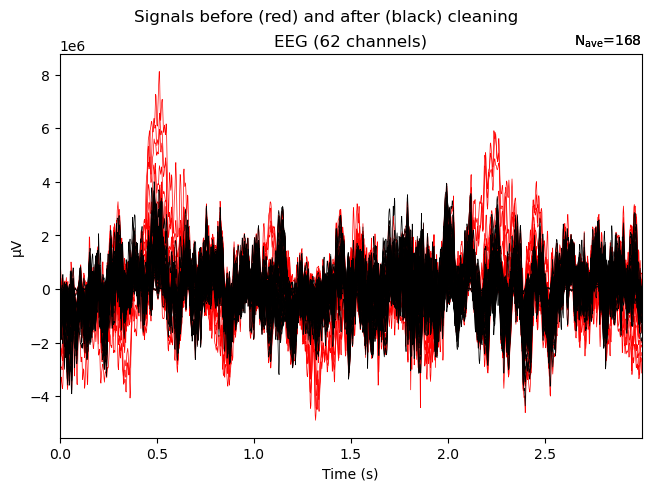

In [88]:
# blinks + heartbeats

ica.exclude = eog_indices+[53]

ica.plot_overlay(epochs.average(), picks="eeg"); # highlights bads

In [92]:
ica.plot_sources(ecg_evoked);

NameError: name 'ecg_evoked' is not defined

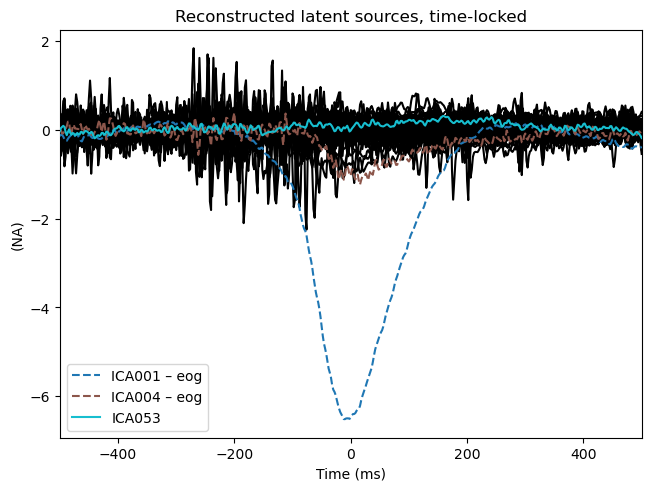

In [94]:
ica.plot_sources(eog_evoked);

In [96]:
ica.apply(epochs, exclude=ica.exclude)

Applying ICA to Epochs instance
    Transforming to ICA space (62 components)
    Zeroing out 3 ICA components
    Projecting back using 62 PCA components


<Epochs | 168 events (all good), 0 – 2.998 s (baseline off), ~127.0 MB, data loaded,
 '1': 168>

In [98]:
ar.fit(epochs)
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
epochs[reject_log.bad_epochs].plot(scalings='auto', title='Bad epochs after second autoreject')

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/62 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/62 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

Dropped 5 epochs: 1, 36, 53, 124, 132


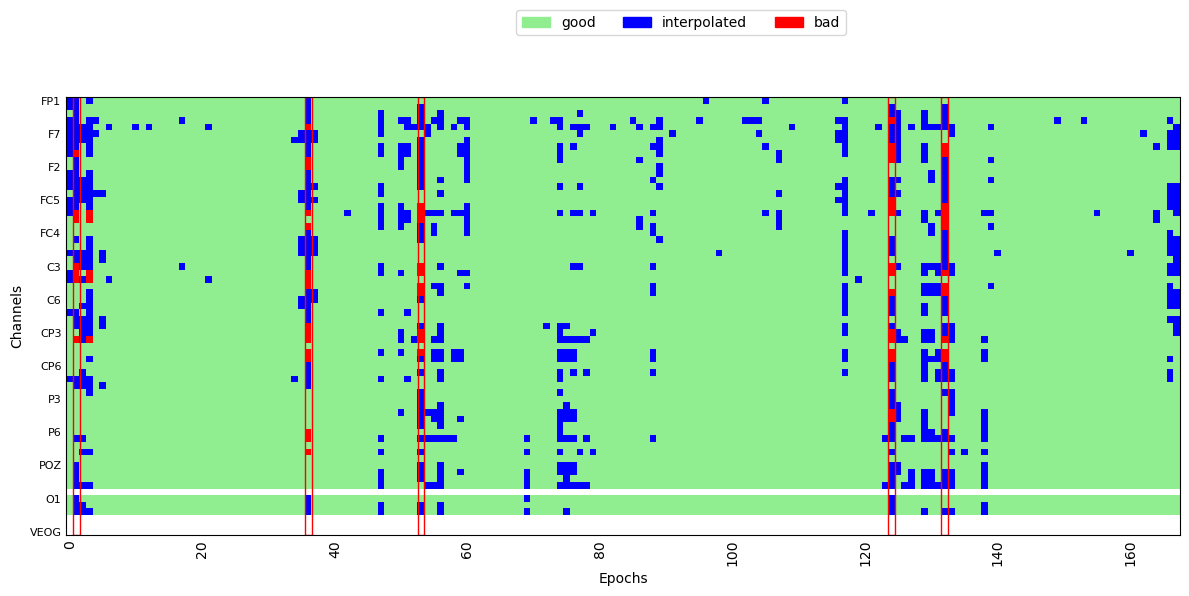

In [100]:
reject_log.plot('horizontal');

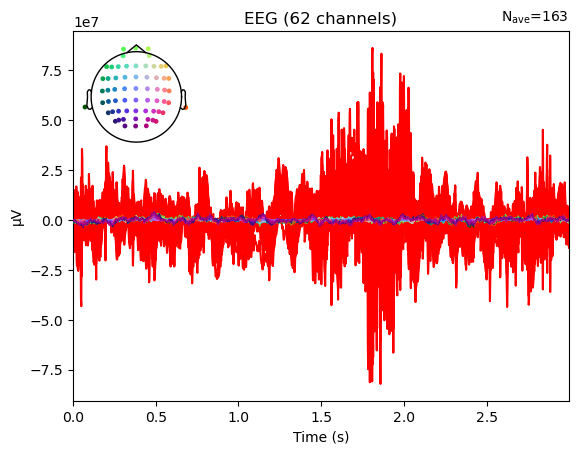

In [102]:
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T*1e6, 'r', zorder = -1);
epochs_ar.average().plot(axes=plt.gca());

In [104]:
epochs_ar = ar.transform(epochs, reject_log = reject_log)
print(f'Number of epochs originally: {len(epochs)}, '
      f'after autoreject: {len(epochs_ar)}')

  0%|          | Repairing epochs : 0/168 [00:00<?,       ?it/s]

Dropped 5 epochs: 1, 36, 53, 124, 132
Number of epochs originally: 168, after autoreject: 163


In [108]:
epochs_ar.plot(scalings='auto', title='Preprocessed data')

In [112]:
epochs_ar.save(r"Files/{}_Depression_REST_CLEANED-epo.fif".format(file_number), overwrite=True);

In [9]:
# IMPORT DATA
epochs_ar = mne.read_epochs(r"Files/{}_Depression_REST_CLEANED-epo.fif".format(file_number))

Reading C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\Files\609_Depression_REST_CLEANED-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2998.00 ms
        0 CTF compensation matrices available
Not setting metadata
163 matching events found
No baseline correction applied
0 projection items activated


In [11]:
eeg_epochs = epochs_ar.load_data().copy().pick('eeg')

In [13]:
# Optional if we want to iterate over all frequency bands

band_list = {'delta': (1,5), 'theta':(4,8), 'alpha': (8,12), 'beta': (13, 30)}

fmin = tuple([list(band_list.values())[f][0] for f in range(len(band_list))])
fmax = tuple([list(band_list.values())[f][1] for f in range(len(band_list))])

In [15]:
min_freq = 4
max_freq = 7
freqs = np.linspace(min_freq, max_freq, 10)

In [122]:
con_pli = spectral_connectivity_time(eeg_epochs, freqs, method='pli', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)
con_pli_data = con_pli.get_data(output='dense')
print(con_pli_data.shape)
con_pli.save(r"Files/{}_Depression_REST_PLI".format(file_number));

only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 163 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_33428\1360599165.py:1: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 163 events (all good), 0 – 2.998 s (baseline off), ~115.7 MB, data loaded,
 '1': 163>, so metadata was not modified.
  con_pli = spectral_connectivity_time(eeg_epochs, freqs, method='pli', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)


   Processing epoch 2 / 163 ...
   Processing epoch 3 / 163 ...
   Processing epoch 4 / 163 ...
   Processing epoch 5 / 163 ...
   Processing epoch 6 / 163 ...
   Processing epoch 7 / 163 ...
   Processing epoch 8 / 163 ...
   Processing epoch 9 / 163 ...
   Processing epoch 10 / 163 ...
   Processing epoch 11 / 163 ...
   Processing epoch 12 / 163 ...
   Processing epoch 13 / 163 ...
   Processing epoch 14 / 163 ...
   Processing epoch 15 / 163 ...
   Processing epoch 16 / 163 ...
   Processing epoch 17 / 163 ...
   Processing epoch 18 / 163 ...
   Processing epoch 19 / 163 ...
   Processing epoch 20 / 163 ...
   Processing epoch 21 / 163 ...
   Processing epoch 22 / 163 ...
   Processing epoch 23 / 163 ...
   Processing epoch 24 / 163 ...
   Processing epoch 25 / 163 ...
   Processing epoch 26 / 163 ...
   Processing epoch 27 / 163 ...
   Processing epoch 28 / 163 ...
   Processing epoch 29 / 163 ...
   Processing epoch 30 / 163 ...
   Processing epoch 31 / 163 ...
   Processing epoc

In [17]:
con_pli = read_connectivity(r"Files/{}_Depression_REST_PLI".format(file_number))

In [19]:
con_wpli = spectral_connectivity_time(eeg_epochs, freqs, method='wpli', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)
con_wpli_data = con_wpli.get_data(output='dense')
print(con_wpli_data.shape)
con_wpli.save(r"Files/{}_Depression_REST_WPLI".format(file_number));

only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 163 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_17872\3898769204.py:1: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 163 events (all good), 0 – 2.998 s (baseline off), ~115.7 MB, data loaded,
 '1': 163>, so metadata was not modified.
  con_wpli = spectral_connectivity_time(eeg_epochs, freqs, method='wpli', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)


   Processing epoch 2 / 163 ...
   Processing epoch 3 / 163 ...
   Processing epoch 4 / 163 ...
   Processing epoch 5 / 163 ...
   Processing epoch 6 / 163 ...
   Processing epoch 7 / 163 ...
   Processing epoch 8 / 163 ...
   Processing epoch 9 / 163 ...
   Processing epoch 10 / 163 ...
   Processing epoch 11 / 163 ...
   Processing epoch 12 / 163 ...
   Processing epoch 13 / 163 ...
   Processing epoch 14 / 163 ...
   Processing epoch 15 / 163 ...
   Processing epoch 16 / 163 ...
   Processing epoch 17 / 163 ...
   Processing epoch 18 / 163 ...
   Processing epoch 19 / 163 ...
   Processing epoch 20 / 163 ...
   Processing epoch 21 / 163 ...
   Processing epoch 22 / 163 ...
   Processing epoch 23 / 163 ...
   Processing epoch 24 / 163 ...
   Processing epoch 25 / 163 ...
   Processing epoch 26 / 163 ...
   Processing epoch 27 / 163 ...
   Processing epoch 28 / 163 ...
   Processing epoch 29 / 163 ...
   Processing epoch 30 / 163 ...
   Processing epoch 31 / 163 ...
   Processing epoc

In [20]:
con_wpli = read_connectivity(r"Files/{}_Depression_REST_WPLI".format(file_number))
con_wpli_data = con_wpli.get_data(output='dense')

In [29]:
con_coh = spectral_connectivity_time(eeg_epochs, freqs, method='coh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)
con_coh_data = con_coh.get_data(output='dense')
print(con_coh_data.shape)
con_coh.save(r"Files/{}_Depression_REST_COH".format(file_number));

only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 163 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_17872\2612165357.py:1: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 163 events (all good), 0 – 2.998 s (baseline off), ~115.7 MB, data loaded,
 '1': 163>, so metadata was not modified.
  con_coh = spectral_connectivity_time(eeg_epochs, freqs, method='coh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)


   Processing epoch 2 / 163 ...
   Processing epoch 3 / 163 ...
   Processing epoch 4 / 163 ...
   Processing epoch 5 / 163 ...
   Processing epoch 6 / 163 ...
   Processing epoch 7 / 163 ...
   Processing epoch 8 / 163 ...
   Processing epoch 9 / 163 ...
   Processing epoch 10 / 163 ...
   Processing epoch 11 / 163 ...
   Processing epoch 12 / 163 ...
   Processing epoch 13 / 163 ...
   Processing epoch 14 / 163 ...
   Processing epoch 15 / 163 ...
   Processing epoch 16 / 163 ...
   Processing epoch 17 / 163 ...
   Processing epoch 18 / 163 ...
   Processing epoch 19 / 163 ...
   Processing epoch 20 / 163 ...
   Processing epoch 21 / 163 ...
   Processing epoch 22 / 163 ...
   Processing epoch 23 / 163 ...
   Processing epoch 24 / 163 ...
   Processing epoch 25 / 163 ...
   Processing epoch 26 / 163 ...
   Processing epoch 27 / 163 ...
   Processing epoch 28 / 163 ...
   Processing epoch 29 / 163 ...
   Processing epoch 30 / 163 ...
   Processing epoch 31 / 163 ...
   Processing epoc

In [30]:
con_coh = read_connectivity(r"Files/{}_Depression_REST_COH".format(file_number))
con_coh_data = con_coh.get_data(output='dense')

In [31]:
print(con_coh_data.shape)
avg_con = np.mean(con_coh_data, axis=2)
print(avg_con.shape)  # Should be (62, 62)
print(avg_con) 

(62, 62, 10)
(62, 62)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.93072202 0.         0.         ... 0.         0.         0.        ]
 [0.89299946 0.97194948 0.         ... 0.         0.         0.        ]
 ...
 [0.43930798 0.44922519 0.45108135 ... 0.         0.         0.        ]
 [0.44408105 0.45841347 0.46531104 ... 0.94964152 0.         0.        ]
 [0.45625745 0.47560206 0.48607485 ... 0.85907207 0.93562999 0.        ]]


In [32]:
# According to Chiarion 2023:
# The mutual information (MI) quantifies the information shared between two random
# variables based on the concept of Shannon entropy [23,95]. In the analysis of two stationary
# random processes, Xi and Xj, the MI is dependent on the time lag separating the two
# variables taken from the processes. A common choice is to compute the MI at lag zero,
# i.e., between the variables Xi,n and Xj,n:
# I(Xi,n; Xj,n) = H(Xi,n) + H(Xj,n) - H(Xi,n, Xj,n),
# This is the sum of the entropies of variables X and Y, minus the joint entropy
# = I(Xi,n; Xj,n) = 1/2 ln(rho^2)

# However, if this just a relationship with rho (Pearson correlation coefficient), then MI might pertain
# more to the time domain rather than the frequency domain

In [33]:
# On the other hand,
# (MIR = mutual information rate)
# "It is worth noting that, in a linear model-based framework, when the processes have
# a joint Gaussian distribution, the MIR can be represented in the frequency domain as the
# logarithmic counterpart of the spectral coherence:"
#
# i_(Xi;Xj) (w) = 1/2 ln (1 - |G_(i,j) (w)|2); -> where G_(i,j) (w) is the gamma function of the corresponding spectral coherence

# coh array is of shape 62,62,10
mir_data = np.zeros((62,62,10))
for epoch in range(10):
    for i in range(62):
        for j in range(62):
            coherence_value = con_coh_data[i, j, epoch]
            mir_data[i,j,epoch] = -(1/2)*log(1-(abs(coherence_value))**2)
print(mir_data.shape)
mir_data.save(r"Files/{}_Depression_REST_MIR".format(file_number));

(62, 62, 10)


AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [ ]:
# The squared Coh can be represented on a logarithmic scale through the spectral
# measure of TD:

td_data = np.zeros((62,62,10))
for epoch in range(10):
    for i in range(62):
        for j in range(62):
            coherence_value = con_coh_data[i, j, epoch]
            td_data[i,j,epoch] = -log(1-(abs(coherence_value))**2)
print(td_data.shape)
td_data.save(r"Files/{}_Depression_REST_WPLI".format(file_number));

In [ ]:
print(eeg_epochs.ch_names)

In [ ]:
min_freq = 3
max_freq = 35
freqs = np.linspace(min_freq, max_freq, 30)

In [22]:
frontal_indices = ([list(range(5,9))], [list(range(10,14))])

frontal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=frontal_indices, method='cacoh', 
                                               average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (4); targets (4)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_28804\3465408248.py:5: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=frontal_indices, method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [74]:
print(f"Results shape: {frontal_con_cacoh.get_data().shape} (connections x frequencies)")

frontal_con_cacoh.save(r"Files/{}_Depression_REST_frontal_CACOH".format(file_number));

In [16]:
frontal_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_frontal_CACOH".format(file_number))

In [84]:
# Anything else for temporal lobe or just T7 and T8?
left_frontal_temporal_indices = ([list(range(5,9))], [[eeg_epochs.ch_names.index('T7')]])

left_frontal_temporal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_temporal_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (4); targets (1)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_28804\1783955909.py:4: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  left_frontal_temporal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_temporal_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [88]:
print(f"Results shape: {left_frontal_temporal_con_cacoh.get_data().shape} (connections x frequencies)")

left_frontal_temporal_con_cacoh.save(r"Files/{}_Depression_REST_left_frontal_temporal_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [18]:
left_frontal_temporal_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_left_frontal_temporal_CACOH".format(file_number))

In [122]:
right_frontal_temporal_indices = ([list(range(10,14))], [[eeg_epochs.ch_names.index('T8')]])

right_frontal_temporal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_temporal_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (4); targets (1)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_28804\1159411850.py:3: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  right_frontal_temporal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_temporal_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [124]:
print(f"Results shape: {right_frontal_temporal_con_cacoh.get_data().shape} (connections x frequencies)")

right_frontal_temporal_con_cacoh.save(r"Files/{}_Depression_REST_right_frontal_temporal_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [20]:
right_frontal_temporal_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_right_frontal_temporal_CACOH".format(file_number))

In [138]:
left_frontal_parietal_indices = ([list(range(5,9))], [list(range(eeg_epochs.ch_names.index('P7'),eeg_epochs.ch_names.index('P1')+1))])

left_frontal_parietal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_parietal_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (4); targets (4)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_65816\2155875661.py:3: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  left_frontal_parietal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_parietal_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [139]:
print(f"Results shape: {left_frontal_parietal_con_cacoh.get_data().shape} (connections x frequencies)")

left_frontal_parietal_con_cacoh.save(r"Files/{}_Depression_REST_left_frontal_parietal_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [140]:
left_frontal_parietal_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_left_frontal_parietal_CACOH".format(file_number))

In [170]:
print([list(range(eeg_epochs.ch_names.index('P2'),eeg_epochs.ch_names.index('P8')+1))], [list(range(eeg_epochs.ch_names.index('P7'),eeg_epochs.ch_names.index('P1')+1))])

[[48, 49, 50, 51]] [[43, 44, 45, 46]]


In [156]:
right_frontal_parietal_indices = ([list(range(10,14))], [list(range(eeg_epochs.ch_names.index('P7'),eeg_epochs.ch_names.index('P1')+1))])

right_frontal_parietal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_parietal_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (4); targets (4)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_65816\1569381997.py:3: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  right_frontal_parietal_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_parietal_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [157]:
print(f"Results shape: {right_frontal_parietal_con_cacoh.get_data().shape} (connections x frequencies)")

right_frontal_parietal_con_cacoh.save(r"Files/{}_Depression_REST_right_frontal_parietal_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [158]:
right_frontal_parietal_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_right_frontal_parietal_CACOH".format(file_number))

In [250]:
left_frontal_within_indices = ([list(range(5,7))], [list(range(7,9))])

left_frontal_within_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_within_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (2); targets (2)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_65816\2456152365.py:3: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  left_frontal_within_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=left_frontal_within_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [252]:
print(f"Results shape: {left_frontal_within_con_cacoh.get_data().shape} (connections x frequencies)")

left_frontal_within_con_cacoh.save(r"Files/{}_Depression_REST_left_frontal_within_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [254]:
left_frontal_within_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_left_frontal_within_CACOH".format(file_number))

In [260]:
right_frontal_within_indices = ([list(range(10,12))], [list(range(12,14))])

right_frontal_within_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_within_indices, 
                                                             method='cacoh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

Estimated data ranks:
    connection 1 - seeds (2); targets (2)
Connectivity computation...
   Processing epoch 1 / 164 ...


C:\Users\fmava\AppData\Local\Temp\ipykernel_65816\3058233170.py:3: RuntimeWarning: There were no Annotations stored in <EpochsFIF | 164 events (all good), 0 – 2.998 s (baseline off), ~116.4 MB, data loaded,
 '1': 164>, so metadata was not modified.
  right_frontal_within_con_cacoh = spectral_connectivity_time(eeg_epochs, freqs, indices=right_frontal_within_indices,


Computing CaCoh for connection 1 of 1
   Processing epoch 2 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 3 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 4 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 5 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 6 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 7 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 8 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 9 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 10 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 11 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 12 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 13 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 14 / 164 ...
Computing CaCoh for connection 1 of 1
   Processing epoch 15 / 164 ...
Computing CaCo

In [262]:
print(f"Results shape: {right_frontal_within_con_cacoh.get_data().shape} (connections x frequencies)")

right_frontal_within_con_cacoh.save(r"Files/{}_Depression_REST_right_frontal_within_CACOH".format(file_number));

Results shape: (1, 30) (connections x frequencies)


In [264]:
right_frontal_within_con_cacoh = read_connectivity(r"Files/{}_Depression_REST_right_frontal_within_CACOH".format(file_number))

**NEXT, try connectivity WITHIN the left and right frontal lobes!!**

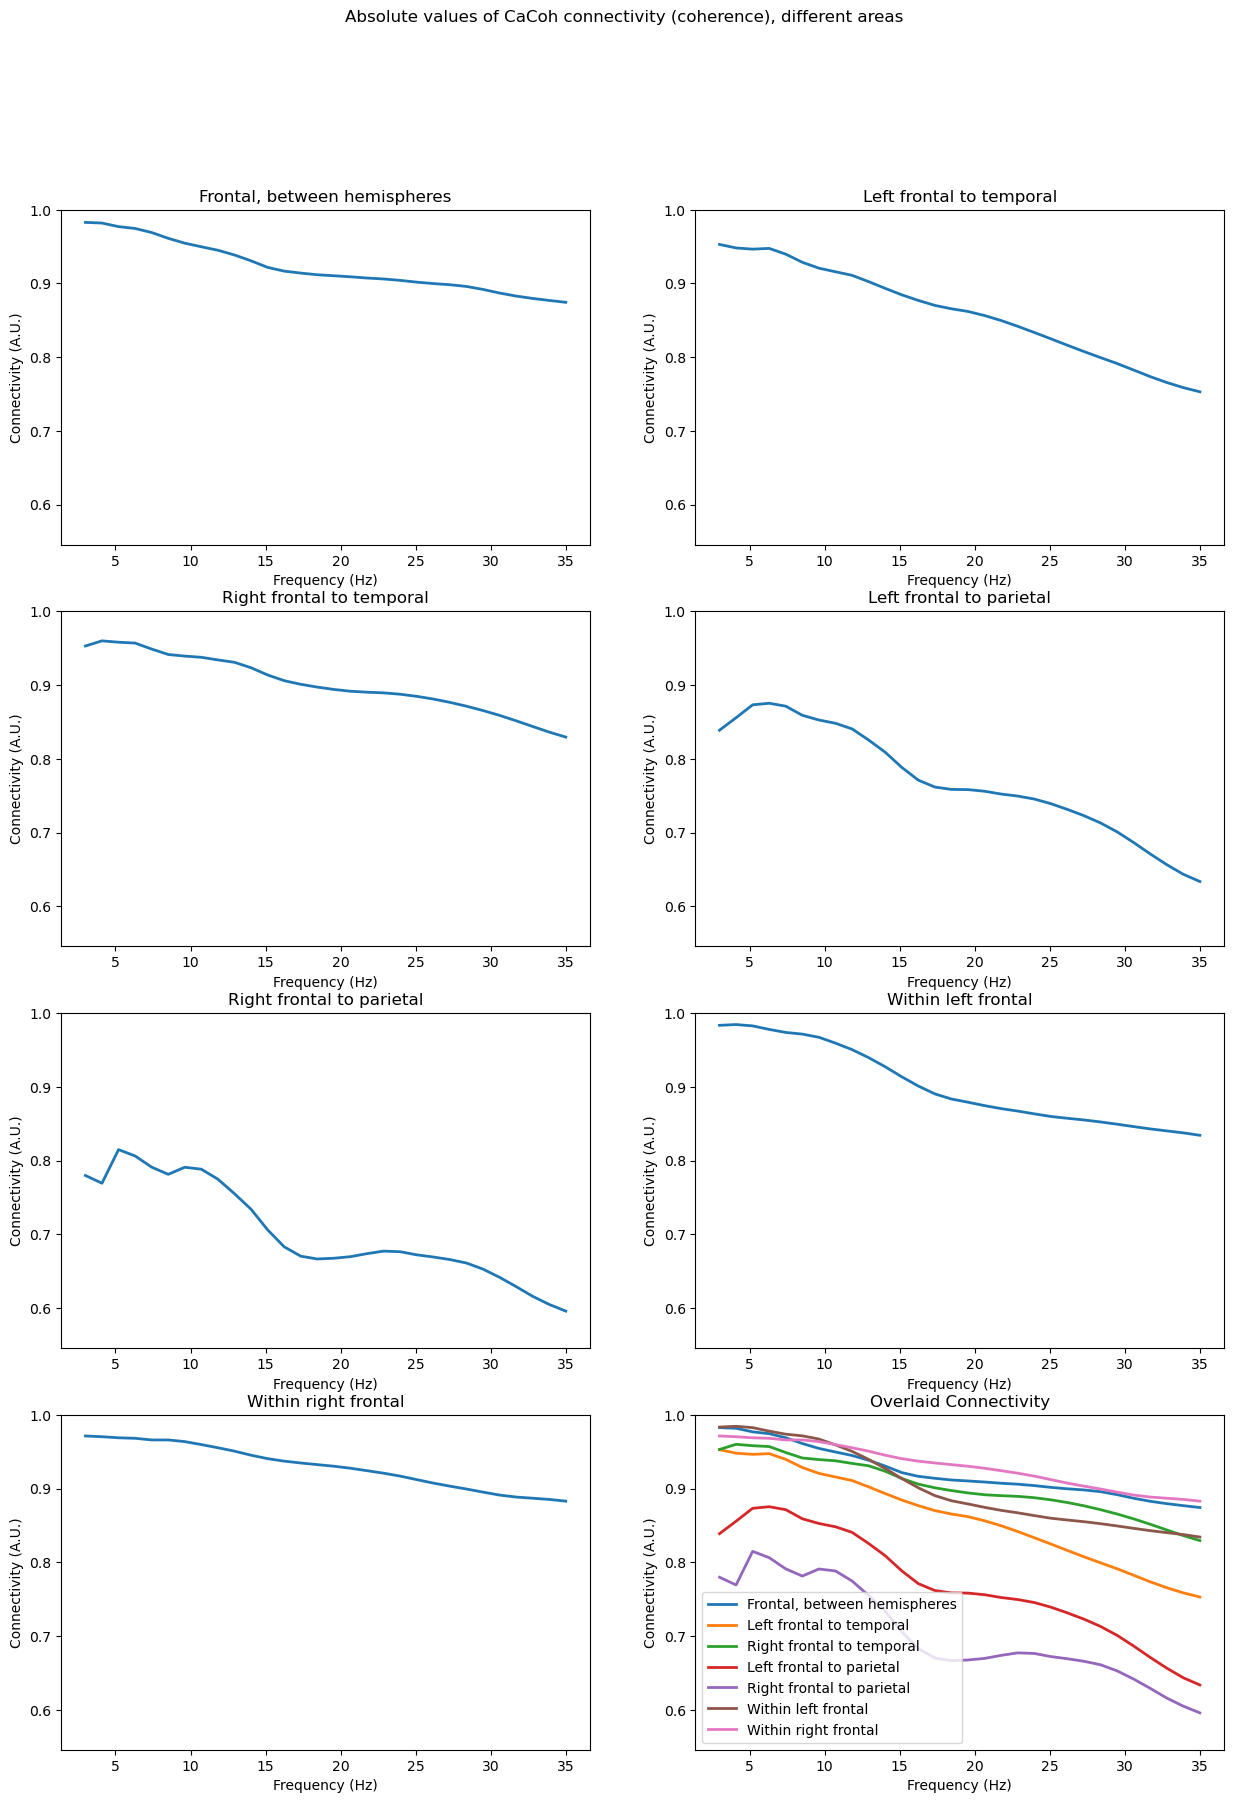

In [266]:
freqs = frontal_con_cacoh.freqs

areas_of_interest = [frontal_con_cacoh, left_frontal_temporal_con_cacoh, right_frontal_temporal_con_cacoh, 
                     left_frontal_parietal_con_cacoh, right_frontal_parietal_con_cacoh, left_frontal_within_con_cacoh,
                     right_frontal_within_con_cacoh] 
titles = ['Frontal, between hemispheres', 'Left frontal to temporal', 'Right frontal to temporal', 
          'Left frontal to parietal', 'Right frontal to parietal', 'Within left frontal', 'Within right frontal']

# Plot CaCoh
fig, axs = plt.subplots(len(areas_of_interest)//2+1, 2, figsize=(15,(len(areas_of_interest)//2+1)*5))
axs = axs.flatten()

y_min = min(np.min(area) for area in abs_plots) - 0.05
y_max = 1.0 # max(np.max(area) for area in abs_plots) + 0.05

for i, (area, title) in enumerate(zip(areas_of_interest, titles)):
    axs[i].plot(freqs, np.abs(area.get_data())[0], linewidth=2)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Connectivity (A.U.)")
    axs[i].set_title(title)
    axs[i].set_ylim(y_min, y_max)

for area, title in zip(areas_of_interest, titles):
    axs[-1].plot(freqs, np.abs(area.get_data())[0], linewidth=2, label=title)
axs[-1].set_xlabel("Frequency (Hz)")
axs[-1].set_ylabel("Connectivity (A.U.)")
axs[-1].set_title("Overlaid Connectivity")
axs[-1].set_ylim(y_min, y_max)
axs[-1].legend()           
    
fig.suptitle("Absolute values of CaCoh connectivity (coherence), different areas")

plt.show(fig)

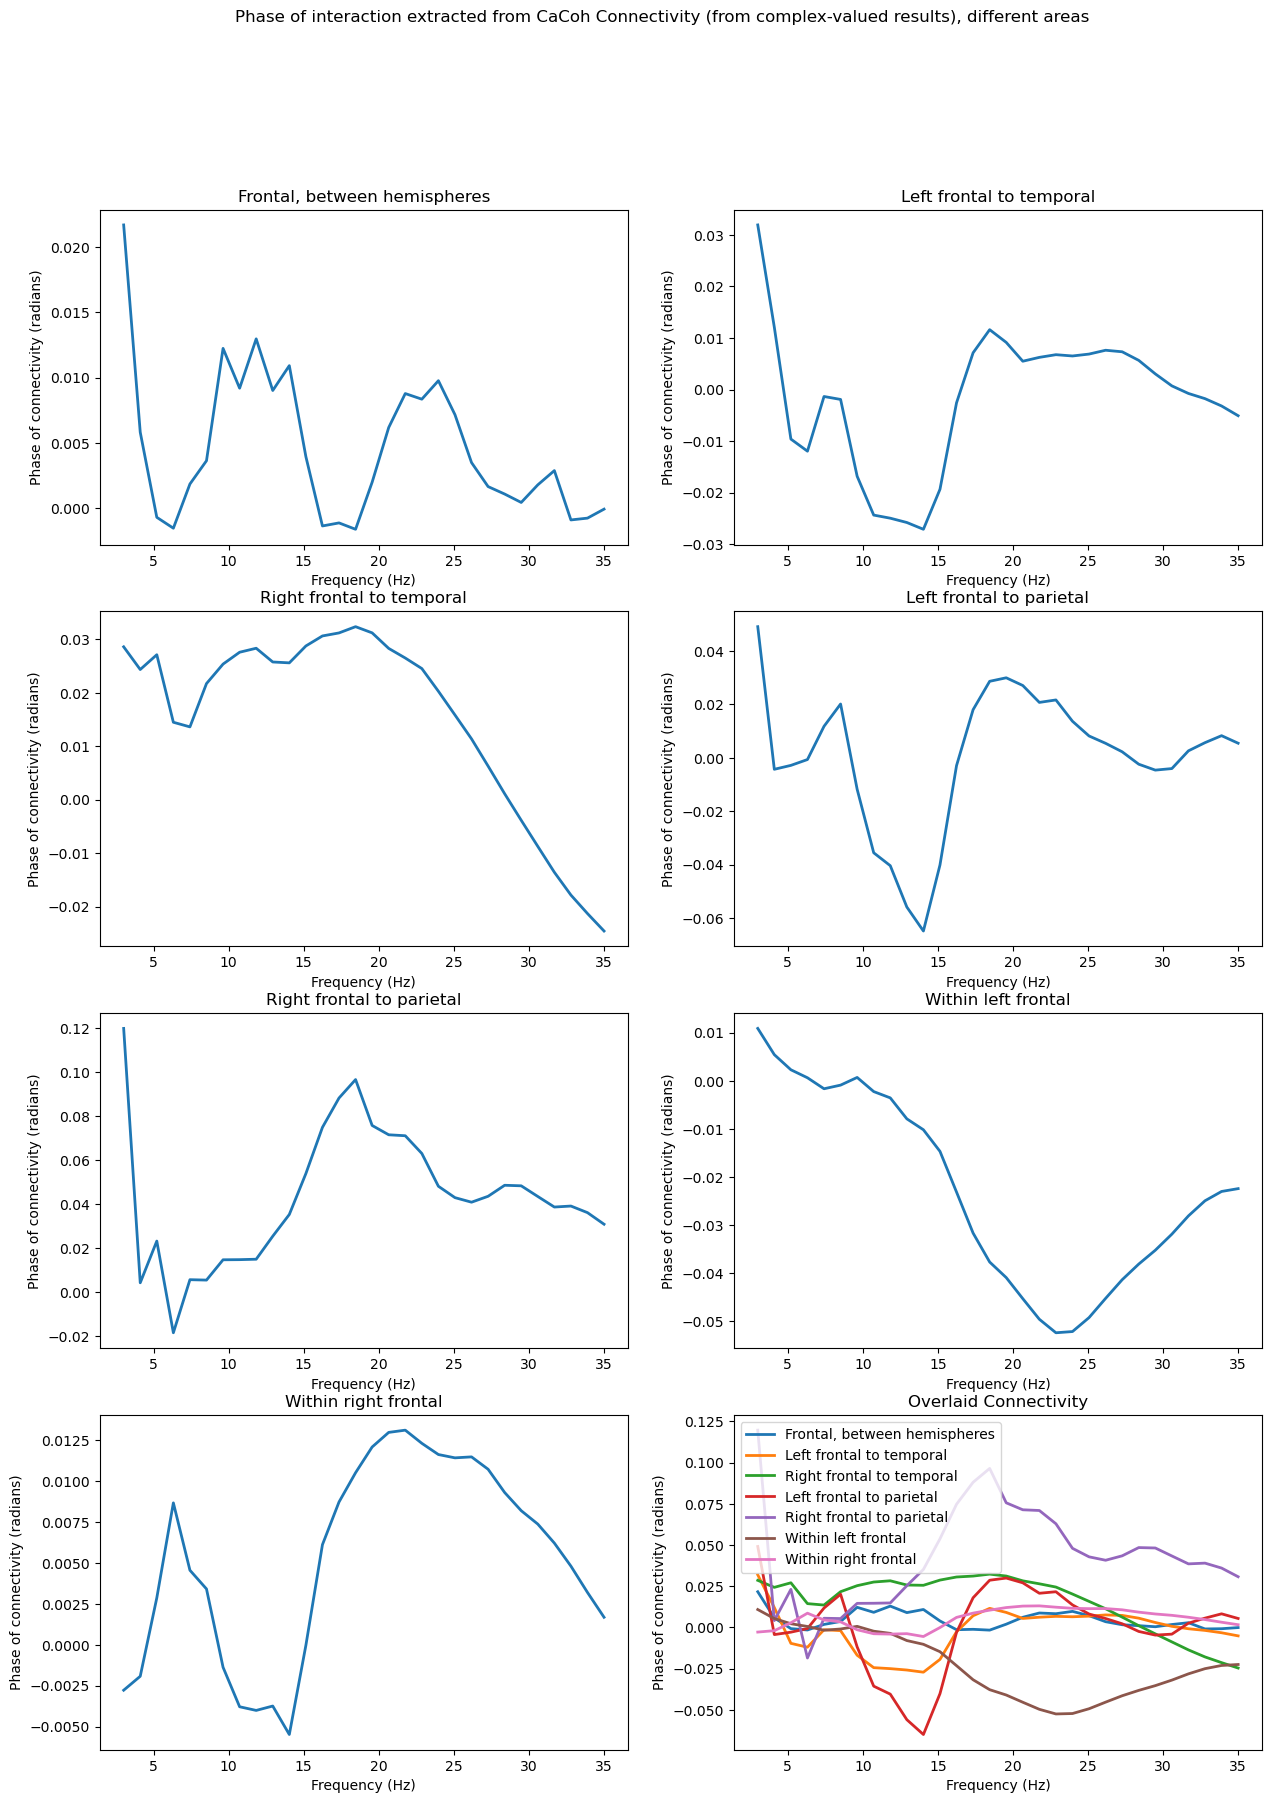

In [270]:
fig, axs = plt.subplots(len(areas_of_interest)//2+1, 2, figsize=(15,(len(areas_of_interest)//2+1)*5))
axs = axs.flatten()

# y_min = min(np.min(area) for np.angle(area) in abs_plots)
# y_max = max(np.max(area) for np.angle(area) in abs_plots)

for i, (area, title) in enumerate(zip(areas_of_interest, titles)):
    axs[i].plot(freqs,  np.angle(area.get_data())[0], linewidth=2)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Phase of connectivity (radians)")
    axs[i].set_title(title)
    # axs[i].set_ylim(y_min, y_max)

for area, title in zip(areas_of_interest, titles):
    axs[-1].plot(freqs, np.angle(area.get_data()[0]), linewidth=2, label=title)
axs[-1].set_xlabel("Frequency (Hz)")
axs[-1].set_ylabel("Phase of connectivity (radians)")
axs[-1].set_title("Overlaid Connectivity")
# axs[-1].set_ylim(y_min, y_max)
axs[-1].legend()           
    
fig.suptitle("Phase of interaction extracted from CaCoh Connectivity (from complex-valued results), different areas")

plt.show(fig)

In [ ]:
# Compute bivariate coherence

con_fullcoh = spectral_connectivity_time(eeg_epochs, freqs, method='coh', average=True, mode='multitaper', fmin=min_freq, fmax=max_freq)

print(f"Original results shape: {con_fullcoh.get_data().shape} (connections x frequencies)")

# Average results across connections
fullcoh_mean = np.mean(con_fullcoh.get_data(), axis=0)
print(f"Averaged results shape: {fullcoh_mean.shape} (connections x frequencies)")

In [56]:
con_fullcoh.save(r"Files/{}_Depression_REST_FULLCOH".format(file_number));

In [40]:
con_pli_data = read_connectivity(r"Files/{}_Depression_REST_PLI".format(file_number)).get_data(output='dense')
con_wpli_data = read_connectivity(r"Files/{}_Depression_REST_WPLI".format(file_number)).get_data(output='dense')
con_coh_data = read_connectivity(r"Files/{}_Depression_REST_COH".format(file_number)).get_data(output='dense')
# con_td_data = read_connectivity(r"Files/{}_Depression_REST_TD".format(file_number)).get_data(output='dense')
# con_mir_data = read_connectivity(r"Files/{}_Depression_REST_MIR".format(file_number)).get_data(output='dense')

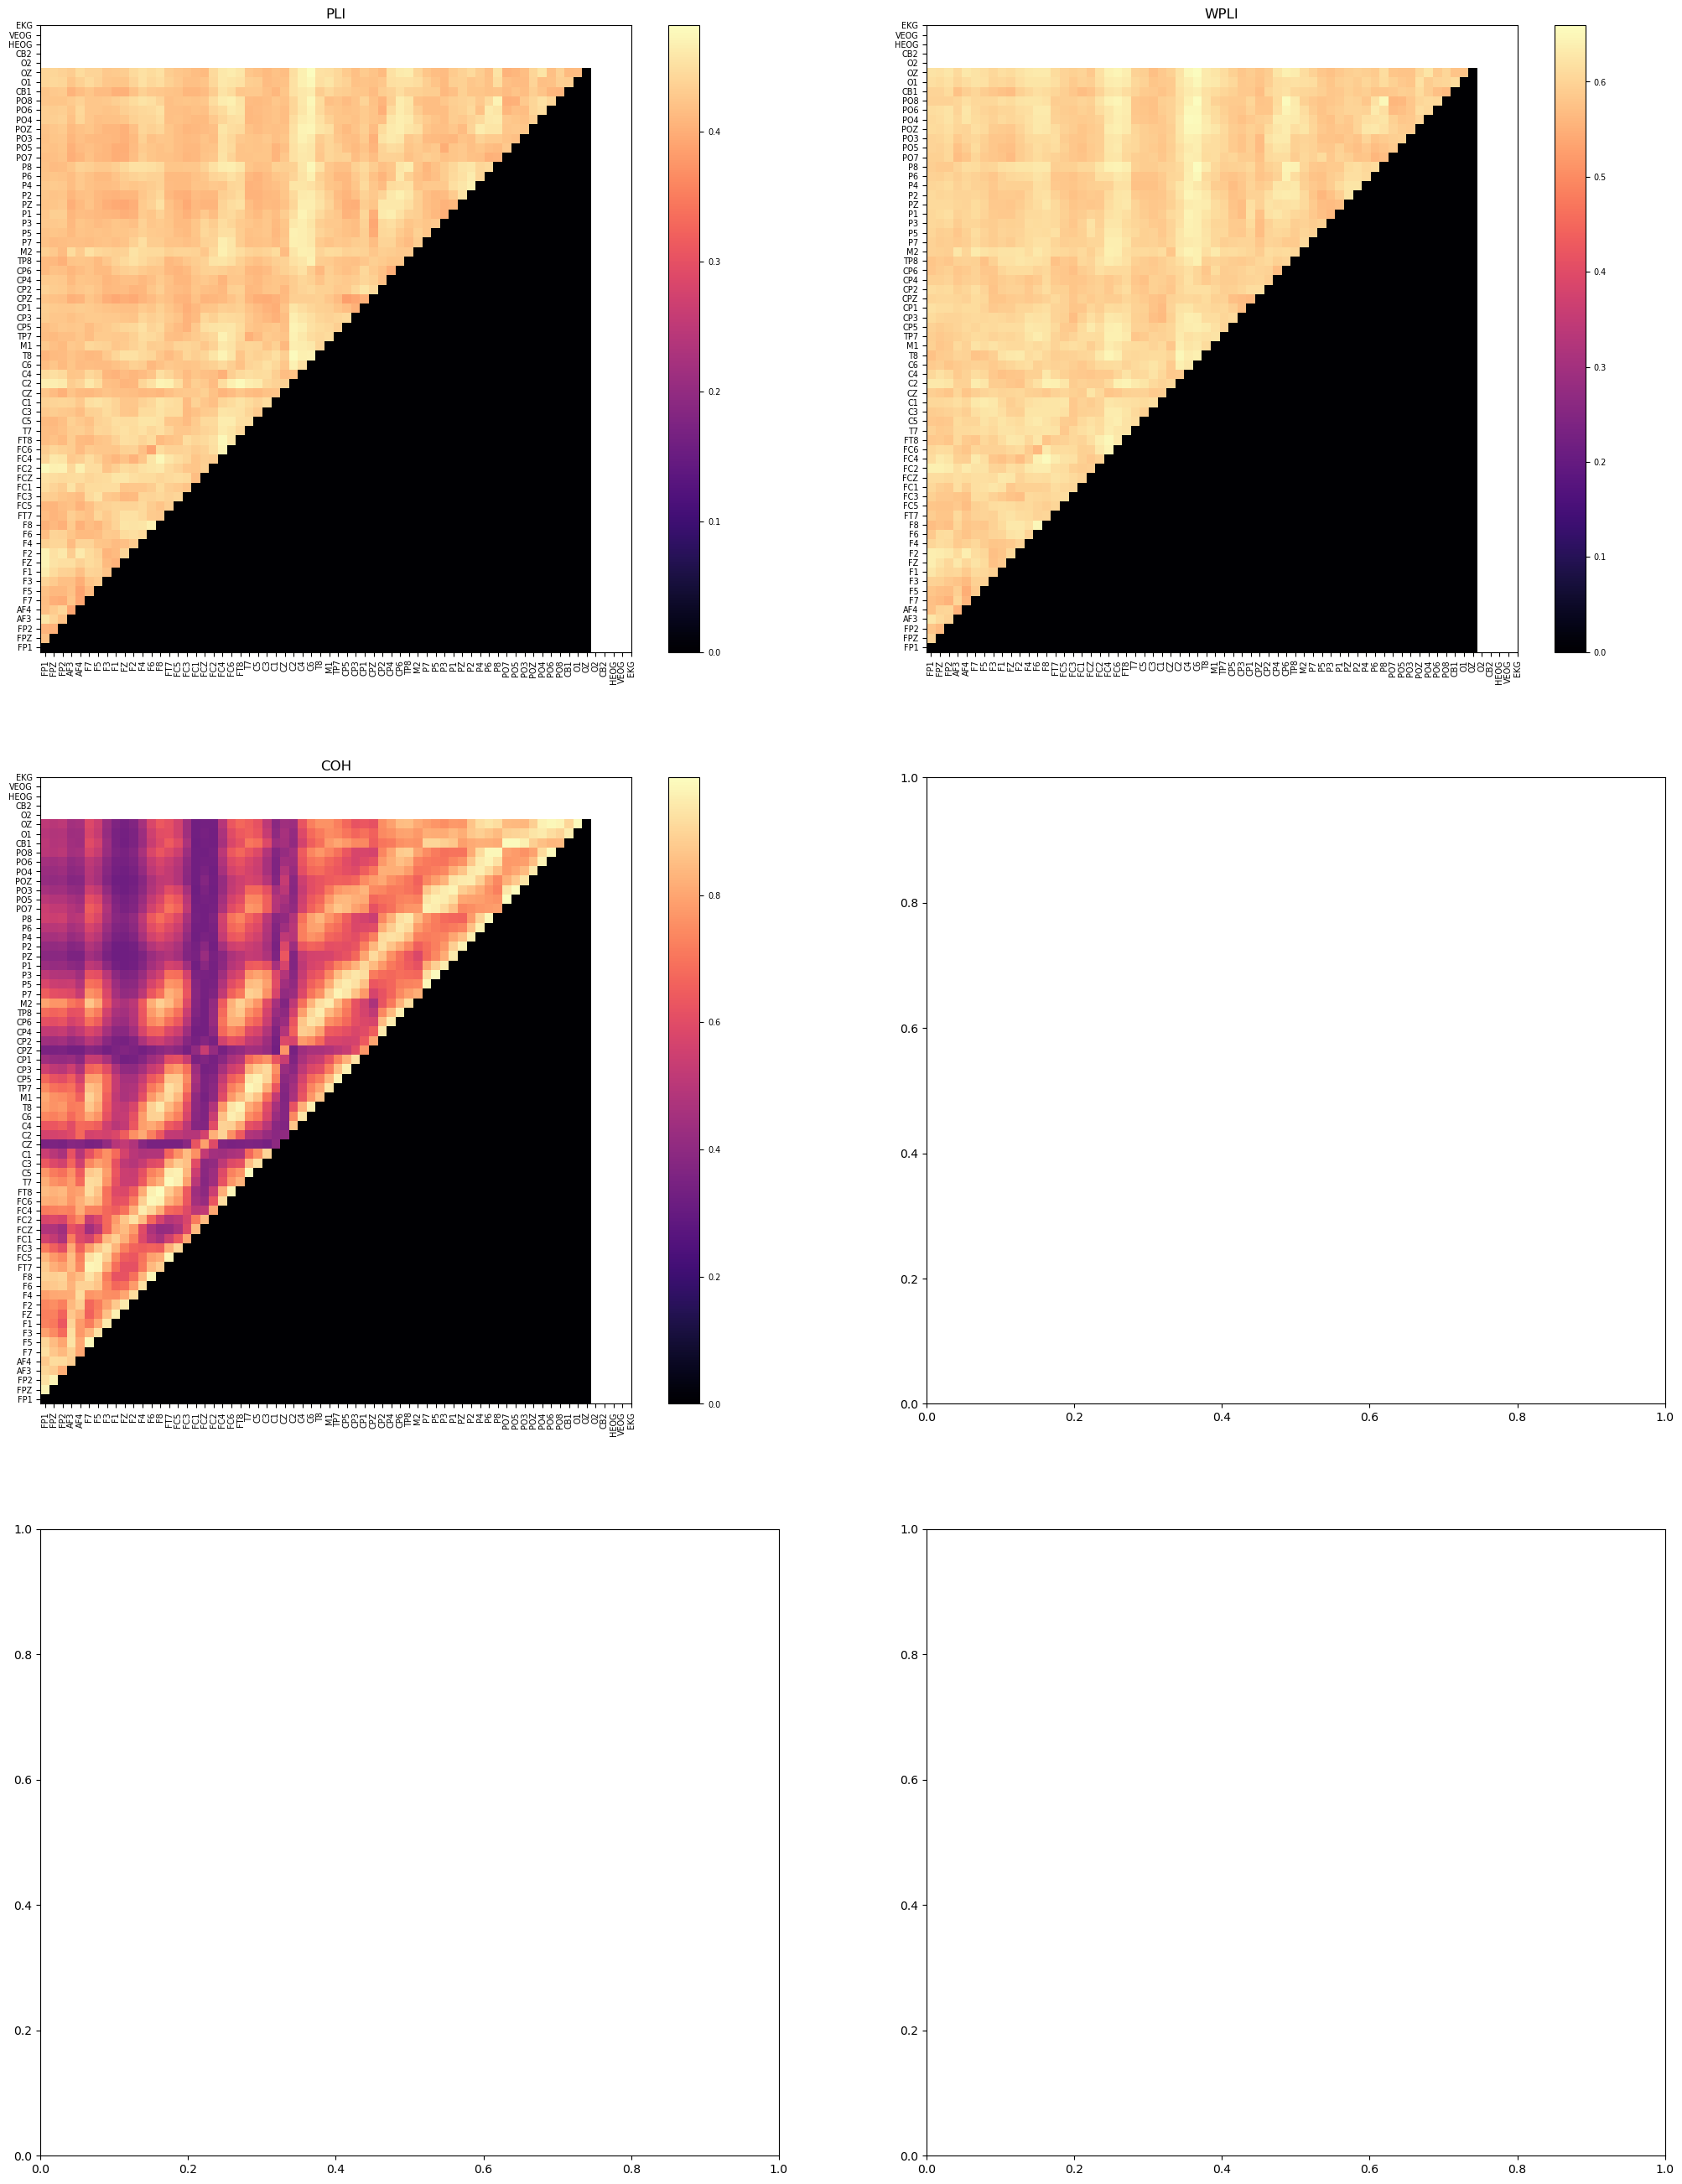

In [52]:
fig, axes = plt.subplots(3,2,figsize=(25,33)) # 3 rows, 2 columns

all_data = [con_pli_data, con_wpli_data, con_coh_data] #, td_data, mir_data
titles = ['PLI', 'WPLI', 'COH'] # , 'TD', 'MIR'

for ax, data, title in zip(axes.flatten(), all_data, titles):
    im = ax.imshow(np.mean(data, axis=2), aspect='auto', cmap='magma', origin='lower')
    ax.set_title(title)
    ax.set_xticks(range(len(channel_names)))
    ax.set_xticklabels(channel_names, fontsize=7, rotation=90)
    ax.set_yticks(range(len(channel_names)), channel_names, fontsize=7)
    ax.set_yticklabels(channel_names, fontsize=7)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=7)
plt.show()

In [104]:
print(np.mean(con_coh_data, axis=2).shape)
print(con_coh_data.shape)

(62, 62)
(62, 62, 10)


In [118]:
plot_sensors_connectivity(eeg_epochs.info, con=np.mean(con_wpli.get_data(output='dense'), axis=2), picks='eeg')

In [177]:
eeg_epochs=eeg_epochs.filter(4,7)
mne.set_eeg_reference(eeg_epochs, ref_channels='average', projection=True)

fsaverage_path = mne.datasets.fetch_fsaverage()

Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.3s
[Parallel(n_job

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
0 files missing from root.txt in C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice
0 files missing from bem.txt in C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage


In [179]:
src_space = mne.setup_source_space('fsaverage', 'ico3', add_dist='True')

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 3

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\lh.white...
Mapping lh fsaverage -> ico (3) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 642/163842 selected to source space (ico = 3)

Loading C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\rh.white...
Mapping rh fsaverage -> ico (3) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\surf\rh.sphere...
Setting up the triang

Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\inner_skull.surf
Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\outer_skull.surf
Using surface: C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\outer_skin.surf


C:\Users\fmava\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


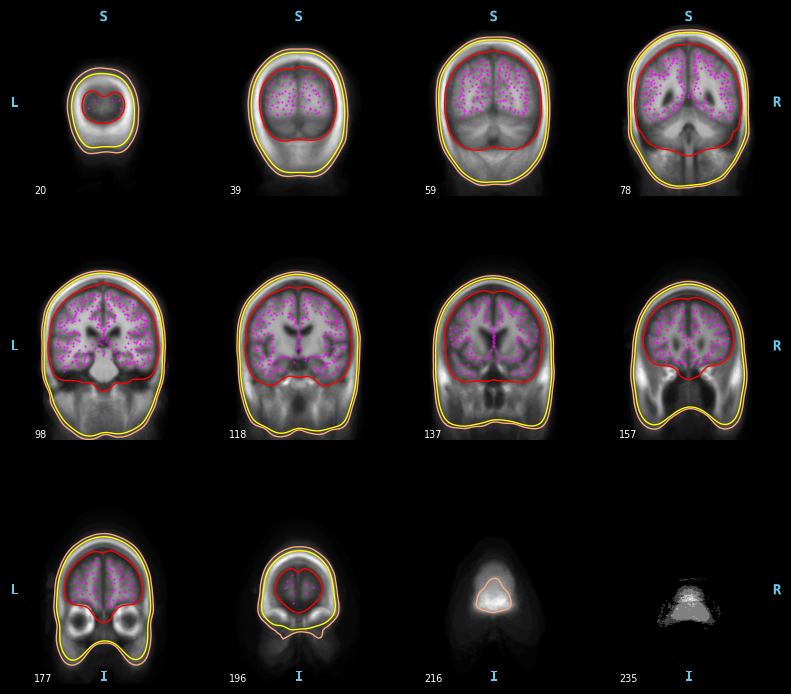

In [59]:
mne.viz.plot_bem('fsaverage', src=src_space);

In [181]:
bem_sol = mne.read_bem_solution('fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif')

Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif


In [187]:
fwd_solution = mne.make_forward_solution(eeg_epochs.info, 'fsaverage', src_space, bem_sol)

# Save solution
mne.write_forward_solution(r"Files/{}_Depression_REST_CLEANED-fwd.fif".format(file_number), fwd_solution, overwrite='True')

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=642>, <surface (rh), n_vertices=163842, n_used=642>] MRI (surface RAS) coords, subject 'fsaverage', ~32.7 MB>
MRI -> head transform : C:\Users\fmava\anaconda3\envs\mne\Lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 1284 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  62 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel 

In [189]:
noise_cov=mne.make_ad_hoc_cov(eeg_epochs.info)

inv_operator = make_inverse_operator(eeg_epochs.info, fwd_solution, noise_cov=noise_cov, depth=None, loose='auto', verbose=True)

mne.minimum_norm.write_inverse_operator(r"Files/{}_Depression_REST_CLEANED-inv.fif".format(file_number), inv_operator, overwrite='True')

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 62 channels.
    62 out of 62 channels remain after picking
Selected 62 channels
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 5.5e-18 (2.2e-16 eps * 62 dim * 0.0004  max singular value)
    Estimated rank (eeg): 61
    EEG: rank 61 computed from 62 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.87968
    scaling factor to adjust the trace = 4.20586e+20 (nchan = 62 nzero = 1)


In [ ]:
# IMPORT DATA
inv_operator = read_inverse_operator(r"Files/{}_Depression_REST_CLEANED-inv.fif".format(file_number))

In [191]:
snr=1.0
lambda2=1.0/snr**2
mne.set_eeg_reference(eeg_epochs, ref_channels='average', projection=True)
stcs=apply_inverse_epochs(eeg_epochs, inv_operator, lambda2=lambda2)

EEG channel type selected for re-referencing
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 61 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 62 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 164
combining the current components...
Processing epoch : 2 / 164
combining the current components...
Processing epoch : 3 / 164
combining the current components...
Processing epoch : 4 / 164
combining the current components...
Processing epoch : 5 / 164
combining the current components...
Processing epoch : 6 / 164
combining the current components...
Processing epoch : 7 / 164
combining the current components...
Processing epoch : 8 / 164
combining the current components...
Pr

C:\Users\fmava\AppData\Local\Temp\ipykernel_110048\3763033418.py:3: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  mne.set_eeg_reference(eeg_epochs, ref_channels='average', projection=True)


combining the current components...
Processing epoch : 13 / 164
combining the current components...
Processing epoch : 14 / 164
combining the current components...
Processing epoch : 15 / 164
combining the current components...
Processing epoch : 16 / 164
combining the current components...
Processing epoch : 17 / 164
combining the current components...
Processing epoch : 18 / 164
combining the current components...
Processing epoch : 19 / 164
combining the current components...
Processing epoch : 20 / 164
combining the current components...
Processing epoch : 21 / 164
combining the current components...
Processing epoch : 22 / 164
combining the current components...
Processing epoch : 23 / 164
combining the current components...
Processing epoch : 24 / 164
combining the current components...
Processing epoch : 25 / 164
combining the current components...
Processing epoch : 26 / 164
combining the current components...
Processing epoch : 27 / 164
combining the current components...
Proc

In [193]:
labels=mne.read_labels_from_annot('fsaverage')
label_colors=[label.color for label in labels]
label_names=[label.name for label in labels]
lh_labels=[name for name in label_names if name.endswith('lh')]
rh_labels=[name for name in label_names if name.endswith('rh')]

label_ypos=list()
for name in lh_labels:
    idx=label_names.index(name)
    ypos=np.mean(labels[idx].pos[:,1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]
rh_labels = [label for (yp, label) in sorted(zip(label_ypos, rh_labels))]

Reading labels from parcellation...
   read 35 labels from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\fmava\Downloads\EEG Learning\MDD Dataset Practice\fsaverage\label\rh.aparc.annot


In [195]:
print(len(lh_labels), len(rh_labels))

35 34


In [197]:
inv_operator['src']

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=282>, <surface (rh), n_vertices=163842, n_used=282>] head coords, subject 'fsaverage', ~42.1 MB>

In [199]:
# Filter out labels that have no vertices in the source space
valid_labels = []
lh_vertices=inv_operator['src'][0]['vertno']
rh_vertices=inv_operator['src'][1]['vertno']

for label in labels:
    label_vertices=label.vertices
    if any(v in lh_vertices for v in label_vertices) or any(v in rh_vertices for v in label_vertices):
        valid_labels.append(label)

In [201]:
print(len(labels))
print(len(valid_labels))

69
63


In [203]:
# Ok, I'm still getting an error saying 'bankssts-lh', 'inferiortemporal-lh' don't contain vertices, so 
# I don't care anymore, I'm just gonna remove them manually

# Define the labels to remove manually (those causing the error)
labels_to_remove = ['bankssts-lh','inferiortemporal-lh']

# Manually filter out labels that are in the `labels_to_remove` list
valid_labels = [label for label in valid_labels if label.name not in labels_to_remove]

In [205]:
print(len(labels))
print(len(valid_labels))

69
61


In [207]:
label_ts=mne.extract_label_time_course(
    stcs, valid_labels, src=inv_operator['src'], mode="mean_flip", return_generator=True
)

In [211]:
from mne_connectivity import spectral_connectivity_epochs

label_cons = spectral_connectivity_epochs(
    label_ts,
    method='pli',
    mode="multitaper",
    fmin=3,
    fmax=7,
    sfreq=eeg_epochs.info['sfreq'],
    faverage=True,
    mt_adaptive=True,
)

Connectivity computation...
Extracting time courses for 61 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..2.998s for estimation (1500 points)
    frequencies: 3.0Hz..7.0Hz (13 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 2
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 3
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 4
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral density for epoch 5
Extracting time courses for 61 labels (mode: mean_flip)
    computing cross-spectral densi

In [212]:
label_cons_data = label_cons.get_data(output='dense').mean(axis=2)

In [213]:
print(label_cons_data.shape)
print(len(valid_labels))

(61, 61)
61


In [217]:
valid_label_names = [label.name for label in valid_labels]
lh_labels=[name for name in valid_label_names if name.endswith('lh')]
rh_labels=[name for name in valid_label_names if not (name.endswith('lh'))]

label_ypos=list()
for name in lh_labels:
    idx=label_names.index(name)
    ypos=np.mean(labels[idx].pos[:,1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for label in sorted(lh_labels)]
rh_labels = [label for label in sorted(rh_labels)]

In [219]:
# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(
    valid_label_names, node_order, start_pos=90, group_boundaries=[0, len(valid_labels) / 2]
)

In [221]:
print(len(node_order))
print(len(valid_labels))
print(len(lh_labels), len(rh_labels))
print(len(valid_label_names))
print(len(node_angles))

61
61
30 31
61
61


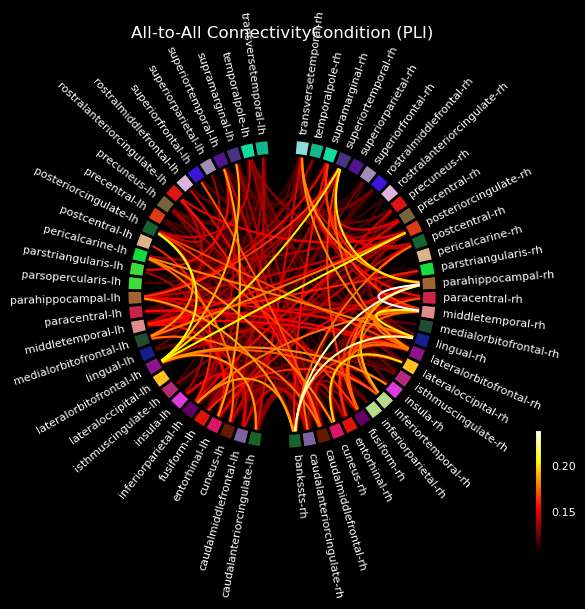

In [223]:
from mne_connectivity.viz import plot_connectivity_circle

con_square_matrix=np.mean(con_time_data, axis=2)

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))

plot_connectivity_circle(
    con=label_cons_data,
    node_names=valid_label_names,
    n_lines=300,
    node_angles=node_angles,
    node_colors=label_colors,
    title="All-to-All Connectivity" "Condition (PLI)",
    ax=ax,
)
fig.tight_layout()